# Computing Project

# Monte Carlo and cluster algorithms for the 2D Ising Model and 2D Hard Disk module

The Ising model for ferromagnets is a common and well researched topic in statistical mechanics both computationally and analytically. Many different algorithms with differing complexities and strengths have been devised to simulate the behaviour of this model. In this project, the behaviour and complexity of the Metropolis-Hastings and Wolff Cluster algorithms applied to this context was investigated. This report focuses particularly on the simulated behaviour at and around the critical temperature $T_c$ of the continuous phase transition, where these algorithms differ. The efficiency of the algorithms is also calculated by means of the dynamic critical exponent.

The Wolff algorithm and Metropolis-Hastings algorithm were studied to assess their efficiency and performance in simulating the 2 dimensional Ising model. An implementation of each was written in python and their behaviour around the continuous phase transtion investigated. Both simulated the large and small temperature limits successfully. The critical temperatures measured were $2.63 \pm 0.08$ and $2.30 \pm 0.08$ for the Wolff and Metropolis-Hasstings algorithms respectively. The Wolff measurement is consistent with previously published values. However, the measurement from the implementation of the Metropolis-Hastings are not consistent with previously published values. The Wolff algorithm displayed shorter autocorrelation times than the Metropolis-Hastings algorithm, showing its lesser vulnerability to the phenomenon of critical slowing down. Attempts to measure the dynamic exponent for both algorithms were far from literature values and neither regression fit was significant. Dependence of time to execute a single iteration on coupling strength and lattice size were also investigated. Wolff had longer single iteration exectution times for all measured conditions, and Metropolis-Hastings execution time displayed no dependence on either condition.

## Section 1 - Background theory

The Ising model considers individual spins, $\sigma_i$, arranged in space. For the purposes of this report, spins will be placed upon an $L\times L$ square lattice. This model assumes that these individual spins may be directed only up or down, i.e. $\sigma_i = \pm 1$, and that each spin interacts with only its nearest neighbours on the lattice. The total energy of the system is then:

$ E = -J \sum_i \sum_j \sigma_i \sigma_j - \mu H \sum_i \sigma_i $ (1) [1]

where for each spin $i$ its nearest neighbours, $j$, are summed over. Additionally, $J$ is the ferromagnetic coupling, $\mu$ is the spin's magnetic moment and $H$ is the external magnetic field. In this report, we will be considering the zero external magnetic field regime.

Typical observables of interest for this system are the magnetism,

$ M  = \frac{1}{N} \sum_{i = 1}^N \sigma_i $ (2)

or, for ensemble systems, the expected total magnetism:

$ \mathbb{E}(M) = \sum_{\sigma states} M(\sigma)p(\sigma)$ (3)

with $p(\sigma)$ being the probabilty density for a specific $\sigma$ state. From statistical mechanics, recall that for such a system,

$ p(\sigma) = \frac{e^{- \beta E}}{Z} $ (4)

Where $Z = \sum_{states} e^{-\beta E_{state}}$ is the partition function, and $\beta = \frac{1}{k_b T}$. For convenience, $\beta = 1$ throughout this report.

However, for a general Ising system, whilst $Z$ is constant it is not feasibly calculable. To illustrate this consider an $N \times N$ lattice of spins. To compute $Z$, we must (at worst) sum up $2^N$ terms for each possible lattice configuration; this sum quickly becomes astronomic in scale. Hence, we must approach this problem in a manner that depends only on relative likelihood, not absolute probability.

In some limiting cases, the behaviour of this system is analytically solvable, for example the Onsager solution for 2 dimensions with no external field, this is typically tedious, or infeasibly complex. This is the motivation for studying this system with computational methods. However, comparison of computational methods to the establsihed Onsager solution is a convenient sanity check for the accuracy and precision.

### The Onsager Solution

In 1944, Onsager found an analytical expression for the free energy and magnetism of the 2D square lattice Ising model in the limit of large lattice and with no eternal magnetic field. Below is the solution for the magnetisation In the case relevant to this report, with isotropic couping:

$\mathbb{E}(M) = (1 - (sinh(2 \beta J)^{-4}))^{\frac{1}{8}} $ for $ T \le T_c $

$\mathbb{E}(M) = 0$ for $ T > T_c $ (5)

The non zero solution clearly is only defined if $sinh(2 \beta J) \ge 1$. This defines our *critical temperature*, $T_c = \frac{2 J}{ln(1 + \sqrt{2})} \approx 2.27J$ . There is a continuous phase transition at $T = T_c$ at which the spins rapidly transition from ordered to disordered, leading to the order parameter, $\vert M \vert$, changing abruptly. Figure 1 plots this solution.

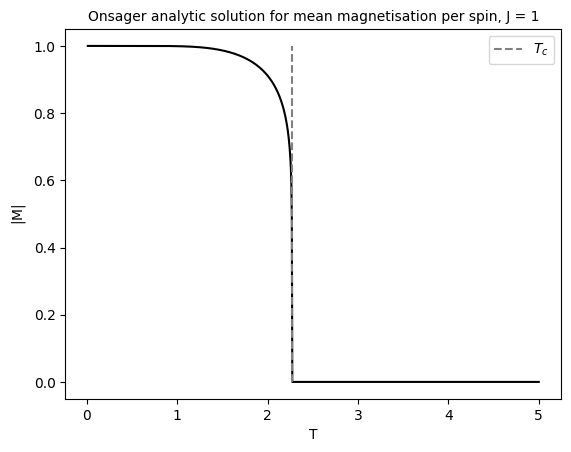

In [45]:
# Firstly, import necessary modules for our program:
import numpy as np
import importlib
rng = np.random.default_rng()  
import matplotlib.pylab as plt
import time
import MH_algorithm as MH
import Wolff_algorithm as W
import init_lattice as lat
import autocorrelation_functions as acf
importlib.reload(MH)
importlib.reload(W)
importlib.reload(lat)
importlib.reload(acf)

# Plot Onsager solution, J = 1:
J = 1
Ts_analytic = np.linspace(0.01,5,1000)
T_c = 2*J/np.log(1 + np.sqrt(2)) # Critical temperature

# Construct absolute magnetism:
M_analytic = []

for T in Ts_analytic:
    if T < T_c:
        M_analytic.append(np.power(1 - np.power(np.sinh(2*J/T),-4),1/8))
    else:
        M_analytic.append(0)

# Plot:
plt.plot(Ts_analytic, M_analytic, color = 'black')
plt.plot(np.full((5,1),T_c), np.linspace(0,1,5), linestyle = '--', color = 'gray', label = r'$T_c$')
plt.xlabel('T')
plt.ylabel(r'$\vert$M$\vert$')
plt.title('Onsager analytic solution for mean magnetisation per spin, J = ' + str(J), fontsize = 10)
plt.legend()
plt.show()

*Fig. 1 - mean magnetisation per spin against temperature for the Onsager solution.*

## Section 2 - Set up

To begin, a model for the lattice was produced on which to implement algorithms. For the purposes of this report, a square lattice with periodic boundary conditions was used. This allows the avoidance of the consideration of edge effects, which cause significant deviations from the Onsager solution. The lattice wasas initiated with a function that produces a list of $N$ items, with each item itself being a list of $N$ items. This trivially has shape $(N,N)$, with each spin having an index $(i,j)$. Each value will be $\pm 1$, and this function will be able to either initiate the lattice in a 'hot' state, with each spin being randomly assigned, or a 'cold' start, where all spins hold the same value. Figure two visualises these three possible initial conditions:

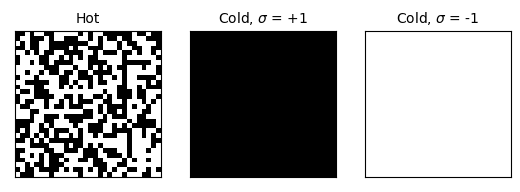

In [6]:
# Initialise lattices:
lattice_cold_plus = lat.make_lattice(30,1)
lattice_cold_minus = lat.make_lattice(30,-1)
lattice_hot = lat.make_lattice(30,0)

# Plot lattices:
fig, ax = plt.subplots(1,3)
lat.show_lattice(lattice_hot, ax[0], 'Hot')
lat.show_lattice(lattice_cold_plus, ax[1], r'Cold, $\sigma$ = +1')
lat.show_lattice(lattice_cold_minus, ax[2], r'Cold, $\sigma$ = -1')

*Fig. 2 - graphical representation of the three possible initial lattice conditions*

## Section 3 - The algorithms

The two algorithms investigated are variations of a Markov Chain Monte Carlo (MCMC) method, that approach and evolve the desired physical state. Direct sampling Monte Carlo, while simpler, would require individually producing each state $X_i$. This is infeasibly slow. Instead, we use the MCMC methods, which produce a state $X_{i + 1}$ from an alteration of the $X_i$ state. One of the downsides of the MCMC methods is that this means consecutive states are not independent. This is quantified by the sample autocorrelation, discussed in more detail in section 4.

The MCMC starts with some initial state, $x_0$, and a state $x_{i+1}$ is produced from a state $x_i$ with a transition probability $p(x_{i + 1} \vert x_{i})$. Therefore the the chance of a particular sequence of states from $x_0$ to $x_n$ is:

$p_{path}(x_0 \rightarrow x_n) = p(x_0)\prod_{i = 0}^n p(x_{i + 1} \vert x_{i})$ (8)

*(This assumes that our markov chain is time homogenous, i.e. the chance of the transition $i \rightarrow j$ is irrelevant of the step in which the transition occurs)*

Suppose now we wish to simply find the chance of arriving at the state $x_n$ in $n$ steps, $p^{(n)}(x)$, regardless of path. Naively, this would involve summing over every singly possible path to every single possible final value to get the full distribution.

This can also be represented as taking a vector $\overrightarrow{p}^{(1)}$ whose $j^{th}$ element is $p^{(1)}(j)$ and acting on it $n-1$ times with a matrix $\textbf{P}$, with elements $\textbf{P}_{ij} = p(i \vert j)$:

$ \overrightarrow{p^{(n)}} = \textbf{P}^{n-1} \overrightarrow{p^{(1)}} $ (9)

For physical systems that reach equilibrium, we expect that, as $ n \rightarrow \infty$, our state vector will approach an unchanging distribution. This is called the *stationary distribution* and is commonly represented with $\pi$. As this stationary distribution does not change, trivially:

$ \pi\textbf{P} = \pi$ (10)

To implement MCMC algorithms, one must look for a method to find the transition matrix, $\textbf{P}$, from the intended stationary distribution. However, for complicated systems such as the Ising model studied here, $\pi$ cannot be analytically calculated and supplied. Therefore a different approach is required.

Firstly, note that our energy equation above is time-reversal symmetric as is the system, hence the probability of $i \rightarrow j$ is equal to the probability $j \rightarrow i$ for a step in the markov chain.

From this follows:

$ \pi_j\textbf{P}_{jk} = \pi_k = \textbf{P}_{jk}\pi_k $ (11)

using the eigenvector property of $\pi$ additionally. This constraint is known as *detailed balance*, and enables the use of simpler distributions to converge on the static distribution.

To approach this, each element of $\textbf{P}$ is split into a proposal probability distribution, $p_prop(j \vert k)$, that gives the chance of attempting to reach state $k$ from $j$, and an acceptance distribution, $p_{acc}(j \rightarrow k)$, that gives the chance of the change of state being accepted:

$ p( j \vert k) = p_{acc}(j \rightarrow k) p_{prop}(j \vert k) $ (12)

With the detailed balance condition, this results in the condition:

$\frac{p_{acc}(j \rightarrow k)}{p_{acc}(k \rightarrow j)} = \frac{\pi_k}{\pi_j} \frac{p_{prop}(j \vert k)}{p_{prop}(k \vert j)} $ (13)

A $p_{acc}$ is sought that satisfies this constraint.

### The Metropolis-Hastings algorithm

The Metropolis-Hasting (MH) algorithm follows the above logic, and the choice of $p_{acc}$ is:

$p_{acc}(j \rightarrow k) = min(1,\frac{\pi_k}{\pi_j} \frac{p_{prop}(j \vert k)}{p_{prop}(k \vert j)})$ (14)

The general MH algorithm proceeds as follows from a starting state $j$:

1. From an initial state $j$, pick a new state $k$ in line with the $p_{prop}$ distribution.
2. Accept the transition to $k$ with probability $p_{acc}(j \rightarrow k)$, and move to state $k$, or reject the move (with probability $ 1 - p_{acc}(j \rightarrow k )$) and remain in state $j$.
3. Return to 1.

This algorithm does not have a defined end point, so the end point is determined in this report by a predetermined number of iterations. This can be defined more rigorously later on, through utilisation of the autocorrelation time, $\tau_f$. Independent samples are generally considered to have occured every $\sim 2 \tau_f$, hence the number of total iterations can be varied, but should be several $\tau_f$.[8]

To apply this to the Ising model, states $j, k, etc.$ are taken to be unique arrangements of spins in the lattice. This means for a lattice containing $N$ spins, there are have $2^N$ possible states. New states $k$ are generated by choosing a random spin in $j$ and flipping it. The spin to flip is chosen from a uniform random distribution, hence $p_{prop}(k \vert j) = \frac{1}{N}$. The sought stationary distributions is equation (4), combining this with (11):

$p_{acc}(j \rightarrow k) = min(1, \frac{e^{-\beta E_k}}{e^{- \beta E_j}}) = min(1, e^{-\beta \Delta E})$ (15)

Notice that the partition function, $Z$, is not a dependent of $p_{acc}$, as it is cancelled in the ratio $\frac{\pi_k}{\pi_j}$.

From equation (1),

$\Delta E = 2 J \sigma_i \sum_j \sigma_j + 2 \mu H \sigma_i  $ (16) [2]

For the flip of a spin at a location $i$, with near neighbours $j$

This algorithm is easy to implement, but has a few shortcomings. Firstly, about the critical temperature, $T_c$, where the lattice undergoes a sharp change in behaviour, the MH algorithm displays an inherent issue of critical slowing down - the lattice has global behaviour which cannot be captured in flipping a single spin, and hence many iterations are required to reach a reliable stationary distribution.

MH also has some intrinisic properties. Firstly, it is a completely general MCMC technique that can be applied to most statistical physics problems, for example it is also applicable to the hard disk crystal model [2]. Additionally, MH can quite easily be parallelised to allow for faster computation.

Sweeps are defined as the number of attempted spin flips per lattice site, i.e. $ sweeps = \frac{N_{flips}}{N_{spins}} $, equivalently the number of attempted flips per spin. Sweeps are used instead of iterations, in anticipation of the Wolff Cluster algorithm, which flips more than one spin at a time. This makes sweeps a better measure of physical time progressed by our algorithms.

### The Wolff Cluster algorithm

The Wolff cluster algorithm is a separate algorithm used for the Ising model. It seeks to reach the stationary distribution quicker, and mitigate the issue of critical slowing down by forming clusters of like spins within the lattice and attempting to flip them all at once. This allows it to reach likely states that are significantly different from the current state in many fewer iterations by flipping a large number of spins together in each iteration. This algorithm as applied to the Ising model proceeds as follows:

1. A random site in the lattice $i$ with spin $\sigma_i$ is picked and added to the cluster.
2. Each neighbour of $i$ that also has spin $\sigma_i$, is added to the cluster with probability $1- e^{-2 \beta J}$.
3. Repeat step 2 for each neighbour added to the cluster until no more spins are added to the cluster.
4. Now that the cluster is defined flip each spin in the cluster and return to step 1. [3]

This is a rejection free algorithm, which means that in each iteration at least one spin is flipped and the state is changed. Therefore, this algorithm will display (usually small) fluctuations about equilibrium, whereas the MH algorithm will not necessarily. Below is an implementation of the Wolff cluster algorithm.

Note here that although the mathematical definition of sweeps has not changed, the implemented calculation of sweeps has. This is because more than one spin can be flipped per iteration in cluster algorithms.

The Wolff algorithm as outlined above is specific to the Ising model and cannot be applied to other problems that require an MCMC approach. This is a major disadvantage in comparison to the MH algorithm. It can be parrallelised like the MH algorithm. [4]

## Section 4 - Investigation

To assess the use of these algorithms, a number of tests are performed below. Firstly, a pictorial representation of the algorithms evolving a $(25 \times 25)$ lattice in the presence of no magnetic field or coupling from a cold start is included below. We expect the spins to reach a thermal equilibrium with roughly zero net spin and random spin position.  

Metropolis Hastings evolution, J = 0:


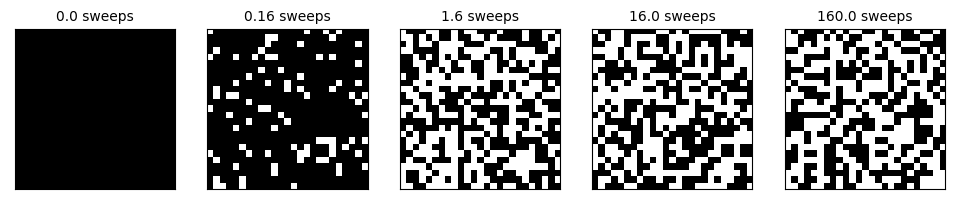

Ran in 1.8696205615997314 seconds


In [12]:
# Initialise lattice
lattice = lat.make_lattice(25,1)
plot_times = [0,100,1000,10000,100000]
# Time run length:
print('Metropolis Hastings evolution, J = 0:')
start_time = time.time()
# Evolve
MH.evolve_and_show(lattice, 2, 0,0, plot_times)
end_time = time.time()
print('Ran in ' + str(end_time - start_time) + ' seconds')

*Fig. 3 - Metropolis-Hasting algorithm evolution of a cold started $25 \times 25$ lattice with no coupling or magnetic field*

Wolff Cluster evolution, J = 0:
Ran in 10.372771739959717 seconds


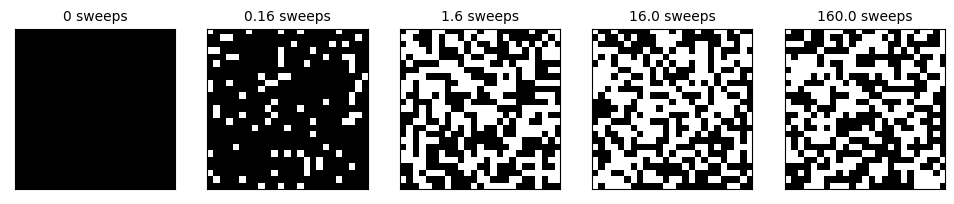

In [13]:
# Re-initialise lattice
lattice = lat.make_lattice(25,1)
print('Wolff Cluster evolution, J = 0:')
# Time run length:
start_time = time.time()
# Evolve
W.Wolff_evolve_and_show(lattice, 2, 0, plot_times)

end_time = time.time()

print('Ran in ' + str(end_time - start_time) + ' seconds')

*Fig. 4 - Metropolis-Hasting algorithm evolution of a cold started $25 \times 25$ lattice with no coupling or magnetic field*

This graphical evolution is similar for both algorithms, and performs as expected. Note that in this case, as $J = 0$, the probability of Wolff to add a second spin to the cluster is $0$, and hence Wolff flips only a single spin in each iteration. It is also clear that in this case the Wolff algorithm runs $\sim 5 \times$ slower. This will be explored further below.

Now, the algorithms will be implemented to determine their agreeability to the Onsager solution. A $25 \times 25$ lattice with coupling constant 1 was evolved for temperatures ranging from 0.1 to 5 using both algorithms. For each temperature, the average absolute mean magnetism per spin was measured. Absolute mean magnetism per spin against temperature is plotted for Wolff, MH and the Onsager solution are plotted in figure 5 below. 

In [265]:
#### SLOW ###

# Initialise lattices:
lattice_MH = lat.make_lattice(30,1)
lattice_Wolff = lat.make_lattice(25,1)

def batch_average(observable):
    # Takes a thermalised variable and batches the data
    tau_f = acf.estimate_correlation_time(acf.compute_autocorrelation(observable))
    print('tau_f = ' + str(tau_f))
    n_batches = int(np.floor(len(observable)/(2*tau_f)))
    print('Data divided into ' + str(n_batches) + ' batches.')
    batch_length = 2*tau_f
    average = []
    average_square = []

    for i in range(n_batches):
        if i == n_batches - 1:
            batch = observable[i*batch_length:]
        else:
            batch = observable[i*batch_length:(i+1)*batch_length] 
        
        average.append(np.mean(batch))
        average_square.append(np.mean(np.power(batch,2)))

    average = np.mean(average)
    average_square = np.mean(average_square)
    err = np.sqrt(((n_batches - 1)**-1)*(average_square - average**2))
    return average, err

# Set temperatures to be evolved at:
Ts_MH = np.linspace(1,5,30)
Ts_Wolff = np.linspace(0.1,5,30)

# Initialise needed averaging times and observable array:
Ms_MH = []
Ms_MH_err = []
Ms_Wolff = []
Ms_Wolff_err = []

# Evolve and loop through Ts:
for T in Ts_MH:
    burn = MH.evolve_and_compute_M(lattice_MH,T**-1, 1, 0, 500000)[0]
    Ms = MH.evolve_and_compute_M(lattice,T**-1,1,0,10000)[0]

    Ms_MH_T, Ms_MH_err_T = batch_average(Ms)
    Ms_MH.append(Ms_MH_T)
    Ms_MH_err.append(Ms_MH_err_T)


# Save data to be re used:
#np.save('MH_M_against_T',Ms_MH)
#np.save('Wolff_M_against_T',Ms_Wolff)

In [243]:
def batch_average(observable):
    # Takes a thermalised variable and batches the data
    tau_f = acf.estimate_correlation_time(acf.compute_autocorrelation(observable))
    n_batches = int(np.floor(len(observable)/(2*tau_f)))
    print('Data divided into ' + str(n_batches) + ' batches.')
    batch_length = 2*tau_f
    average = []
    average_square = []

    for i in range(n_batches):
        if i == n_batches - 1:
            batch = observable[i*batch_length:]
        else:
            batch = observable[i*batch_length:(i+1)*batch_length] 
        
        average.append(np.mean(batch))
        average_square.append(np.mean(np.power(batch,2)))

    average = np.mean(average)
    average_square = np.mean(average_square)
    err = np.sqrt(((n_batches - 1)**-1)*(average_square - average**2))
    return average, err


In [264]:
lattice = lat.make_lattice(50,1)
burn = MH.evolve_and_compute_M(lattice,0.7**-1,1,0,500000)[0]
Ms = MH.evolve_and_compute_M(lattice,0.7**-1,1,0,100000)[0]
print(batch_average(Ms))

tau_f = 3686
Data divided into 13 batches.
(0.9999478859718687, 5.699075237887536e-05)


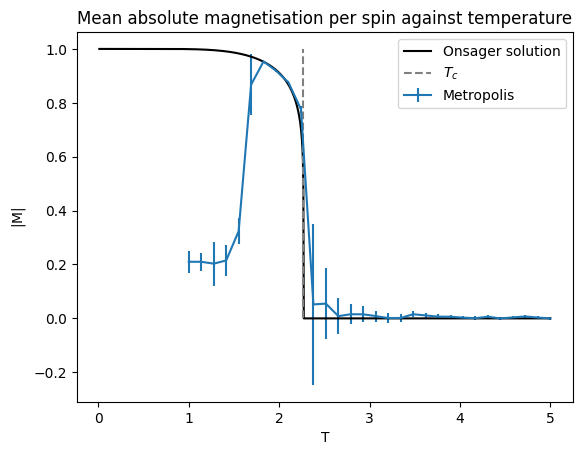

In [259]:
#Ts_MH = np.linspace(0.1,5,30)
Ts_Wolff = np.linspace(0.1,5,30)
#Ms_MH = np.load('MH_M_against_T.npy')
#Ms_Wolff = np.load('Wolff_M_against_T.npy')
plt.errorbar(Ts_MH, np.abs(Ms_MH), yerr = Ms_MH_err, label = 'Metropolis')
plt.plot(Ts_analytic, M_analytic, color = 'black', label  = 'Onsager solution')
#plt.plot(Ts_Wolff, Ms_Wolff, label = 'Wolff')
plt.plot(np.full((5,1),T_c), np.linspace(0,1,5), linestyle = '--', color = 'gray', label = r'$T_c$')
plt.xlabel('T')
plt.ylabel(r'$\vert$M$\vert$')
plt.title(r'Mean absolute magnetisation per spin against temperature')
plt.legend()
plt.show()

*Fig. 5 - mean absolute magnetism per spin against temperature for the Metropolis-Hastings and Wolff algorithms as well as the Onsager analytical solution.*

It is clear that while the MH algorithm perfoms in accordance with the Onsager solution with $T$ far from $T_c$, the behaviour near the critical temperature deviates significantly from the Onsager solution. This a representation of the issue of *critical slowing down* for the MH algorithm. About the critical temperature, the lattice fluctuates on all scales. This behaviour cannot be reproduced by the local single spin flips by which MH proceeds, and hence to get a reliable simulation near $T_c$, an infeasibly large number of iterations is needed.

For the above behaviour to be sampled, the algorithm must have converged to near the stationary distribution for representative $\vert M \vert$ to be taken. The Wolff algorithm requires many fewer iterations to reach this point, for the above $\sim 10$ times fewer. This is due to the Wolff algorithm being less affected by critical slowing down, and is explored further below.

## Critical slowing down

The issue of critical slowing down is most present in the MH algorithm, around $T_c$. The lattice undergoes fluctuations on all scales which is not well captured by the single spin flips of MH. Hence, many iterations are required.

In [20]:
## SLOW

lattice1 = lat.make_lattice(50,1)
lattice2 = lat.make_lattice(50,1)
T1 = 2
T2 = 2.8
M1 = MH.evolve_and_compute_M(lattice1, T1**-1,1,0,100000)[0]
M2 = MH.evolve_and_compute_M(lattice2,T2**-1,1,0,100000)[0]
np.save('MH_lattice_below_T_c', lattice1)
np.save('MH_lattice_above_T_c', lattice2)
np.save('MH_M_below_T_c',M1)
np.save('MH_M_above_T_c',M2)

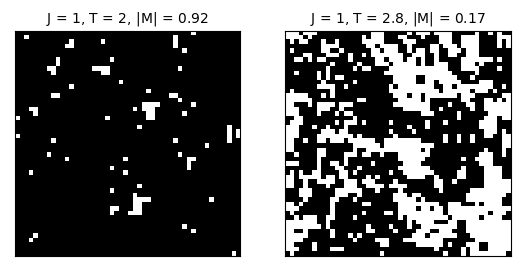

In [21]:
T1 = 2
T2 = 2.8
M1 = np.load('MH_M_below_T_c.npy')
M2 = np.load('MH_M_above_T_c.npy')
fig, ax = plt.subplots(1,2)
lat.show_lattice(lattice1, ax[0], 'J = 1, T = ' + str(T1) + r', $\vert$M$\vert$ = ' + str(round(M1[-1],2)))
lat.show_lattice(lattice2, ax[1], 'J = 1, T = ' + str(T2) + r', $\vert$M$\vert$ = ' + str(round(M2[-1],2)))

*Fig. 6 - A graphical representation of a $50 \times 50$ lattice above below the critical temperature.*

The figure above illustrates the significant difference in structure over the lattice above and below $T_c$. At $T_c$, a very large proportion of the possibles states are thermodynamically likely, due to this being a phase transition. At this scale, the states remain correlated over many iterations and therefore generating independent samples requires significantly more iterations.  

## Autocorrelation Time

It is already clear that the MH algorithm perfoms less well than Wolff about the phase trasition, as MH takes many iterations to alter the lattice state significantly. This is equivalent to saying that the autocorrelation time becomes very large about $T_c$. The autocorrelation time measures the typical number of iterations (or sweeps) required between samples for these samples to be considered independent. Therefore for a large autocorrelation time, the number of iterations required to converge on equilibrium and the number required between independent samples become large and the process overall is less efficient.

To estimate the autocorrelation time, the *sample autocorrelation*, $\bar\rho(t)$ is required:

$\bar\rho(t) = \frac{\bar\gamma(t)}{\bar\gamma(0)}$ (17)

Where $\bar\gamma(t)$ is the *sample autocovariance*, defined below:

$\bar\gamma(t) = \frac{1}{n-t}\sum_{i=1}^{n-t}(f(X_i)-\bar f(X))(f(X_{i+t})-\bar f(X))$ (18)

This sample autocorrelation is a convenient measure of the degree of correlation of the observable $f$ on state $X_t$ at time $t$ with other states in the chain. To determine autocorrelation time, it is assumed that $\bar\rho(t)$ decays exponentially, with the characteristic decay scale of the autocorrelation time, $\tau_f$:

$\bar\rho(t) \approx e^{{t}/{\tau_f}}$ (19) [5]

Under this assumption, the autocorrelation time is estimated by the time of the first value of $\bar\rho(t)$ such that $\bar\rho(t) \le \frac{1}{e}$.

Note that, for values far from $T_c$, the autocorrelation is sufficiently small that python's 64-bit floats round it to zero, or nan. In this case, equation (19) can not be applied, and the autocorrelation time must be assumed to be $0$. The below code plots the sample autocorrelation against sweeps for different physical conditions using both the Wolff and MH algorithms:

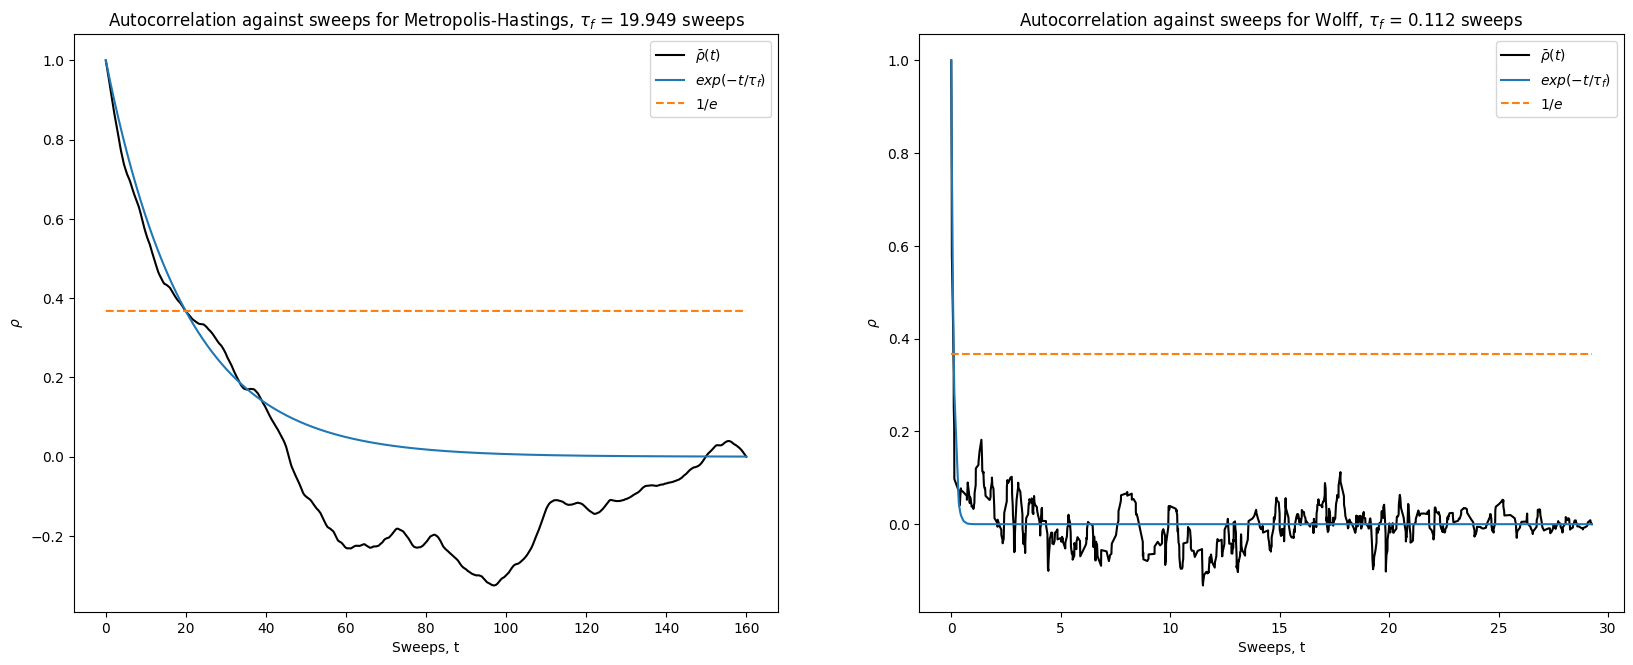

In [228]:


sweeps_MH = np.load('MH_autocorr_evolution_sweeps.npy')
autocorr_MH = np.load('MH_autocorr_evolution_autocorr.npy')
sweeps_tau_f_MH = np.load('MH_autocorr_evolution_sweeps_tau_f.npy')
# plot computed autocorrelation
fig, ax = plt.subplots(1,2, figsize = (20,7.5))
ax[0].plot(sweeps_MH,autocorr_MH, color = 'black', label = r'$\bar{\rho}(t)$')
# plot expected exponential decay behaviour
ax[0].plot(sweeps_MH,[np.exp(-t/sweeps_tau_f_MH) for t in sweeps_MH], label = r'$exp(-t/ \tau_f)$')
# plot 1/e line
ax[0].plot(sweeps_MH, [np.exp(-1) for x in sweeps_MH], label = r'$1/e$', linestyle = '--')
ax[0].set_xlabel('Sweeps, t')
ax[0].set_ylabel(r'$\rho$')
ax[0].set_title(r'Autocorrelation against sweeps for Metropolis-Hastings, $\tau_f$ = ' + str(np.round(sweeps_tau_f_MH,3)) + ' sweeps')
ax[0].legend()


# Load simulation data for Wolff as runtime much larger
sweeps_Wolff = np.load('Wolff_autocorr_evolution_sweeps.npy')
autocorr_Wolff = np.load('Wolff_autocorr_evolution_autocorr.npy')
sweeps_tau_f_Wolff = np.load('Wolff_auto_corr_evolution_sweeps_tau_f.npy')
# plot computed autocorrelation
ax[1].plot(sweeps_Wolff,autocorr_Wolff, color = 'black', label = r'$\bar{\rho}(t)$')
# plot expected exponential decay behaviour
ax[1].plot(sweeps_Wolff,[np.exp(-t/sweeps_tau_f_Wolff) for t in sweeps_Wolff], label = r'$exp(-t/ \tau_f)$')
# plot 1/e line
ax[1].plot(sweeps_Wolff, [np.exp(-1) for x in sweeps_Wolff], label = r'$1/e$', linestyle = '--')
ax[1].set_xlabel('Sweeps, t')
ax[1].set_ylabel(r'$\rho$')
ax[1].set_title(r'Autocorrelation against sweeps for Wolff, $\tau_f$ = ' + str(round(sweeps_tau_f_Wolff.tolist(),3)) + ' sweeps')
ax[1].legend()
plt.show()


*Fig. 7 - plots of sample autocorrelation against sweeeps for a $25 \times 25$  lattice at $T = 2.1$ and $J = 1$ for the Metropolis-Hastings and Wolff algorithms.*

Both computed $\bar\rho(t)$ conform nicely to the expected exponential decay, with noisy behaviour that is apparent after a few autocorrelation times. It is also apparent that the autocorrelation time is smaller for the Wolff algorithm than the MH algorithm for the same given initial conditions. This is a reflection of the larger scale updates made by the Wolff algorithm, allowing it to explore the state space in fewer iterations. This is an indication that the Wolff algorithm has a less pronounced issue of ciritical slowing down. To explore this further, the dependence of autocorrelation time on temperature will be explored below. For thirty temperatures ranging from $0.1$ to $5$, a $50 \times 50$ lattice was evolved with each algorithm five times and an average autocorrelation time calculated. Figure 8 below plots this data.

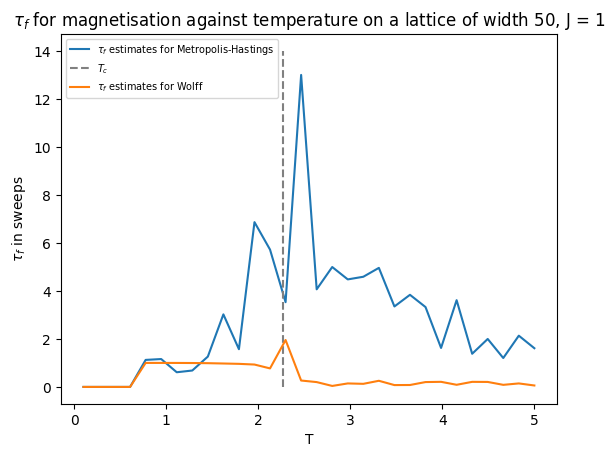

2.2965517241379314


In [234]:

autocorr_times_MH = np.load('MH_autocorrelation_against_T.npy')
Ts = np.linspace(0.1,5,30)
# plot the data:
plt.plot(Ts,autocorr_times_MH, label = r'$\tau_f$ estimates for Metropolis-Hastings')
# mark T_c:
plt.plot(np.full((10,1),T_c),np.linspace(0,np.max(autocorr_times_MH)+1,10), color = 'gray', linestyle = '--', label = r'$T_c$')
plt.xticks([0,1,2,3,4,5])
plt.title(r'$\tau_f$ for magnetisation against temperature on a lattice of width 50, J = 1')

autocorr_times_Wolff = np.load('Wolff_autocorrelation_against_T.npy')
plt.plot(Ts,autocorr_times_Wolff, label = r'$\tau_f$ estimates for Wolff')
plt.xticks([0,1,2,3,4,5])
plt.ylabel(r'$\tau_f$ in sweeps')
plt.xlabel('T')
plt.legend(loc = 'upper left', fontsize = 7)
plt.show()

T_c_Wolff = Ts[np.where(autocorr_times_Wolff == np.max(autocorr_times_Wolff))[0][0]]
T_c_MH = Ts[np.where(autocorr_times_MH == np.max(autocorr_times_MH))[0][0]]
np.save('T_c_MH.npy', T_c_MH)
np.save('T_c_Wolff.npy', T_c_Wolff)
print(T_c_Wolff)


*Fig. 8 - autocorrelation time agains temperature for the Wolff and Metropolis-Hastings algorithms against temperature. $T_C$ is plotted for reference.*

In [ ]:
### Slow ###

# Initialise required variables for MH tau against T:
Ts = np.linspace(0.1,5,30)
max_time = 50000
autocorr_times = []

for T in Ts:
    for i in range(5):
        # Lattice must be reset in each iteration
        lattice = lat.make_lattice(30,1)
        # evolve the lattice
        Ms = MH.evolve_and_compute_M(lattice, T**-1, 1, 0, max_time)[0]
        # find autocorrelation time and add to list.
        autocorr_times_i = []
        autocorr = acf.compute_autocorrelation(Ms)
        sweeps_tau_f = acf.estimate_correlation_time(autocorr)/np.size(lattice)
        autocorr_times_i.append(sweeps_tau_f)
    autocorr_times.append(np.mean(autocorr_times_i))
    print(T)
np.save('MH_autocorrelation_against_T', autocorr_times)

# Initialise required variables for Wolff tau against T:
Ts = np.linspace(0.1,5,30)
max_time = 1000
autocorr_times = []

for T in Ts:
    for i in range(5):
        # Lattice must be reset after each iteration
        lattice = lat.make_lattice(30,1)
        # evolve the lattice
        Ms, sweeps = W.Wolff_evolve_and_compute_M(lattice, T**-1, 1, max_time)
        # find autocorrelation time and add to list.
        autocorr_times_i = []
        autocorr = acf.compute_autocorrelation(Ms)
        sweeps_tau_f = sweeps[acf.estimate_correlation_time(autocorr)]
        autocorr_times_i.append(sweeps_tau_f)
    autocorr_times.append(np.mean(autocorr_times_i))
    print(T)

#save arrays for use in report
np.save('Wolff_autocorrelation_against_T.npy', autocorr_times)


In [204]:
Ts = np.linspace(2.2,2.6,15)
max_time = 50000
autocorr_times = []

for T in Ts:
    for i in range(5):
        # Lattice must be reset in each iteration
        lattice = lat.make_lattice(30,1)
        # evolve the lattice
        Ms = MH.evolve_and_compute_M(lattice, T**-1, 1, 0, max_time)[0]
        # find autocorrelation time and add to list.
        autocorr_times_i = []
        autocorr = acf.compute_autocorrelation(Ms)
        sweeps_tau_f = acf.estimate_correlation_time(autocorr)/np.size(lattice)
        autocorr_times_i.append(sweeps_tau_f)
    autocorr_times.append(np.mean(autocorr_times_i))
    print(T)
#np.save('MH_autocorrelation_against_T', autocorr_times)

# Initialise required variables for Wolff tau against T:
Ts = np.linspace(2.2,2.6,15)
max_time = 1000
autocorr_times = []

for T in Ts:
    for i in range(5):
        # Lattice must be reset after each iteration
        lattice = lat.make_lattice(30,1)
        # evolve the lattice
        Ms, sweeps = W.Wolff_evolve_and_compute_M(lattice, T**-1, 1, max_time)
        # find autocorrelation time and add to list.
        autocorr_times_i = []
        autocorr = acf.compute_autocorrelation(Ms)
        sweeps_tau_f = sweeps[acf.estimate_correlation_time(autocorr)]
        autocorr_times_i.append(sweeps_tau_f)
    autocorr_times.append(np.mean(autocorr_times_i))
    print(T)

#save arrays for use in report
#np.save('Wolff_autocorrelation_against_T.npy', autocorr_times)


2.2
2.2285714285714286
2.257142857142857
2.285714285714286
2.3142857142857145
2.342857142857143
2.3714285714285714
2.4000000000000004
2.428571428571429
2.4571428571428573
2.4857142857142858
2.5142857142857142
2.5428571428571427
2.5714285714285716
2.6
2.2
2.2285714285714286


KeyboardInterrupt: 

It is evident that the autocorrelation time for both algorithms is larger around $T_c$ than far from it. However, the Wolff algorithm maintains a smaller autocorrelation time around this point, again showing that the larger scale updates allow for much better modelling of the Ising model's phase transition. In fact, this cluster method produces a lower autocorrelation time on most measured temperatures.

This behaviour shows the issue of critical slowing down as a limitation of these algorithms. At $T \sim T_c$, the autocorrelation time grows in magnitude. Therefore, the required number of iterations needed between collection of uncorrelated samples becomes much larger, and the CPU time to collect data grows.

The peak in autocorrelation time for MH is at a temprature a small amount above $T_c$. This partly is due to the fact that the Onsager solution assumes an infinite spatial extent of the lattice, whereas a finite lattice with periodic boundary conditions is utilised in the report, which yields:

$T_c(L) = T_c(\infty) +  \alpha L^{-1/\nu}$ (20)[6]

Where L is the lattice width, $\alpha$ is a constant and $\nu$ is the Ising model critical exponent.

This does not explain why MH and Wolff algorithms display different peak positions. Further investigation is required to explain this feature of figure 8.

The value of the critical temperature for each method is estimated using the temperature of the maximum autocorrelation time, with discretisation error from the temperature scales considered in the error. These measured values are: $T_c = 2.47 \pm 0.08$ for MH and $T_c = 2.30 \pm 0.08$ for Wolff. The Onsager value is $T_c = 2.26(9...)$. This is consistent with the Wolff measurement and not with the MH.

The reduced equilibrium time of the Wolff algorithm is illustrated by the magnetisation graph below:

In [ ]:
#### SLOW ####

lattice = lat.make_lattice(100,1)
T = 5
MH_Ms, MH_sweeps = MH.evolve_and_compute_M(lattice, T**-1, 1,0,100000)
MH_autocorr = acf.compute_autocorrelation(MH_Ms)
MH_sweeps_tau_f = MH_sweeps[acf.estimate_correlation_time(MH_autocorr)]
lattice = lat.make_lattice(100,1)
Wolff_Ms, Wolff_sweeps = W.Wolff_evolve_and_compute_M(lattice,T**-1, 1, 100000)


Wolff_autocorr = acf.compute_autocorrelation(Wolff_Ms)
Wolff_sweeps_tau_f = Wolff_sweeps[acf.estimate_correlation_time(Wolff_autocorr)]
np.save('MH_M_evolution.npy', MH_Ms)
np.save('MH_sweeps_evolution.npy', MH_sweeps)
np.save('MH_sweeps_tau_f.npy', MH_sweeps_tau_f)
np.save('Wolff_M_evolution.npy', Wolff_Ms)
np.save('Wolff_sweeps_evolution.npy', Wolff_sweeps)
np.save('Wolff_sweeps_tau_f.npy', Wolff_sweeps_tau_f)



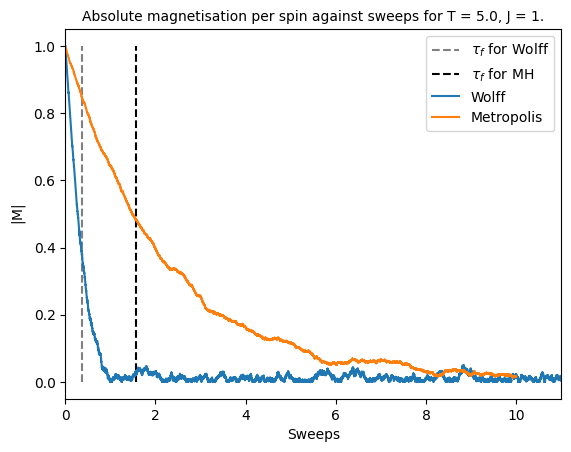

In [43]:
# Load simulation data:
Wolff_Ms = np.load('Wolff_M_evolution.npy')
Wolff_sweeps = np.load('Wolff_sweeps_evolution.npy')
Wolff_sweeps_tau_f = np.load('Wolff_sweeps_tau_f.npy')
MH_Ms = np.load('MH_M_evolution.npy')
MH_sweeps = np.load('MH_sweeps_evolution.npy')
MH_sweeps_tau_f = np.load('MH_sweeps_tau_f.npy')
plt.plot(np.full((3,1),Wolff_sweeps_tau_f),np.linspace(0,1,3), linestyle = '--', color = 'gray', label = r'$\tau_f$ for Wolff')
plt.plot(np.full((3,1),MH_sweeps_tau_f),np.linspace(0,1,3), linestyle = '--', color = 'black', label = r'$\tau_f$ for MH')
plt.plot(Wolff_sweeps, Wolff_Ms, label = 'Wolff')
plt.xlim((0,MH_sweeps[-1]+1))
plt.plot(MH_sweeps,MH_Ms, label = 'Metropolis')
plt.xlabel('Sweeps')
plt.ylabel(r'$\vert$M$\vert$')
plt.title('Absolute magnetisation per spin against sweeps for T = ' + str(T) + ', J = 1.', fontsize = 10)
plt.legend()
plt.show()


*Fig. 9 - Absolute magnetism per spin against algorithm sweeps for the Metropolis-Hastings and Wolff algorithms on a $100 \times 100$ lattice.*

### Dynamic exponent

The issue of critical slowing down can be further quantified by measurement of the *dynamic exponent*, $z$:

$\tau_f \sim \xi^z \sim \vert T - T_c \vert ^{z \nu}$ (21) [7]

where $\xi$ is the correlation length, $\nu$ is the critical exponent, which is a universal property of the Ising model. It has an analytic value $\nu = 1$[10] in 2-dimensions.

On a finite lattice of length $L$, the correlation length cannot exceed $L$.Therefore it is expected that the correlation length near $T_c$ to approximately equal the system length. This yields:

$\tau_f \sim L^z$ for $T \sim T_c$ (22)

$ln(\tau_f) \sim zln(L)$ (23)

$\tau_f$ was calculated for successive lattice widths from two to thirty spins. This was calculated from an average of $15$ simulations; $5$ simulations of each possible initial condition were performed. $J$ was held constant at $1$ and the temperature was constant, at the critical temperature for each algorithm as estimated from figure 8. The results for each algorithm are plotted on a logarithmic scales in figure 10 below. Least squares linear regression was performed to determine the measured critical dynamic exponent for each algorithm.

In [ ]:
#####SLOW#####

lattice_widths = [2**(i + 1) for i in range(5)]
MH_autocorr_time_against_width = []
MH_autocorr_time_against_width_err = []
for width in lattice_widths:
    for i in range(5):
        MH_temp = []
        lattice = lat.make_lattice(width,1)
        Ms, sweeps = MH.evolve_and_compute_M(lattice,T_c_MH**-1,1,0,10000)
        MH_autocorr = acf.compute_autocorrelation(Ms)
        MH_temp.append(acf.estimate_correlation_time(MH_autocorr))
        lattice = lat.make_lattice(width,0)
        Ms, sweeps = MH.evolve_and_compute_M(lattice,T_c_MH**-1,1,0,10000)
        MH_autocorr = acf.compute_autocorrelation(Ms)
        MH_temp.append(acf.estimate_correlation_time(MH_autocorr))
        lattice = lat.make_lattice(width,-1)
        Ms, sweeps = MH.evolve_and_compute_M(lattice,T_c_MH**-1,1,0,10000)
        MH_autocorr = acf.compute_autocorrelation(Ms)
        MH_temp.append(acf.estimate_correlation_time(MH_autocorr))
    MH_autocorr_time_against_width.append(np.mean(MH_temp))
    MH_autocorr_time_against_width_err.append(np.std(MH_temp))
    print(MH_autocorr_time_against_width)

Wolff_autocorr_time_against_width = []
Wolff_autocorr_time_against_width_err = []

for width in lattice_widths:
    for i in range(5):
        Wolff_temp = []
        lattice = lat.make_lattice(width,1)
        Ms, sweeps = W.Wolff_evolve_and_compute_M(lattice,T_c_Wolff**-1,1,1001)
        Wolff_autocov = acf.compute_autocorrelation(Ms)
        Wolff_temp.append(acf.estimate_correlation_time(Ms))
        lattice = lat.make_lattice(width,1)
        Ms, sweeps = W.Wolff_evolve_and_compute_M(lattice,T_c_Wolff**-1,1,1001)
        Wolff_autocov = acf.compute_autocorrelation(Ms)
        Wolff_temp.append(acf.estimate_correlation_time(Ms))
        lattice = lat.make_lattice(width,1)
        Ms, sweeps = W.Wolff_evolve_and_compute_M(lattice,T_c_Wolff**-1,1,1001)
        Wolff_autocov = acf.compute_autocorrelation(Ms)
        Wolff_temp.append(acf.estimate_correlation_time(Ms))       
    Wolff_autocorr_time_against_width.append(np.mean(Wolff_temp))
    Wolff_autocorr_time_against_width_err.append(np.std(Wolff_temp))
    print(Wolff_autocorr_time_against_width)

np.save('MH_autocorr_time_against_width.npy', MH_autocorr_time_against_width)
np.save('Wolff_autocorr_time_against_width.npy', Wolff_autocorr_time_against_width)


[  36.          333.33333333 1171.66666667  823.66666667 1086.
 2058.33333333 2055.66666667]
[[0.69314718 1.        ]
 [1.38629436 1.        ]
 [2.07944154 1.        ]
 [2.77258872 1.        ]
 [3.4657359  1.        ]
 [4.15888308 1.        ]
 [4.85203026 1.        ]]


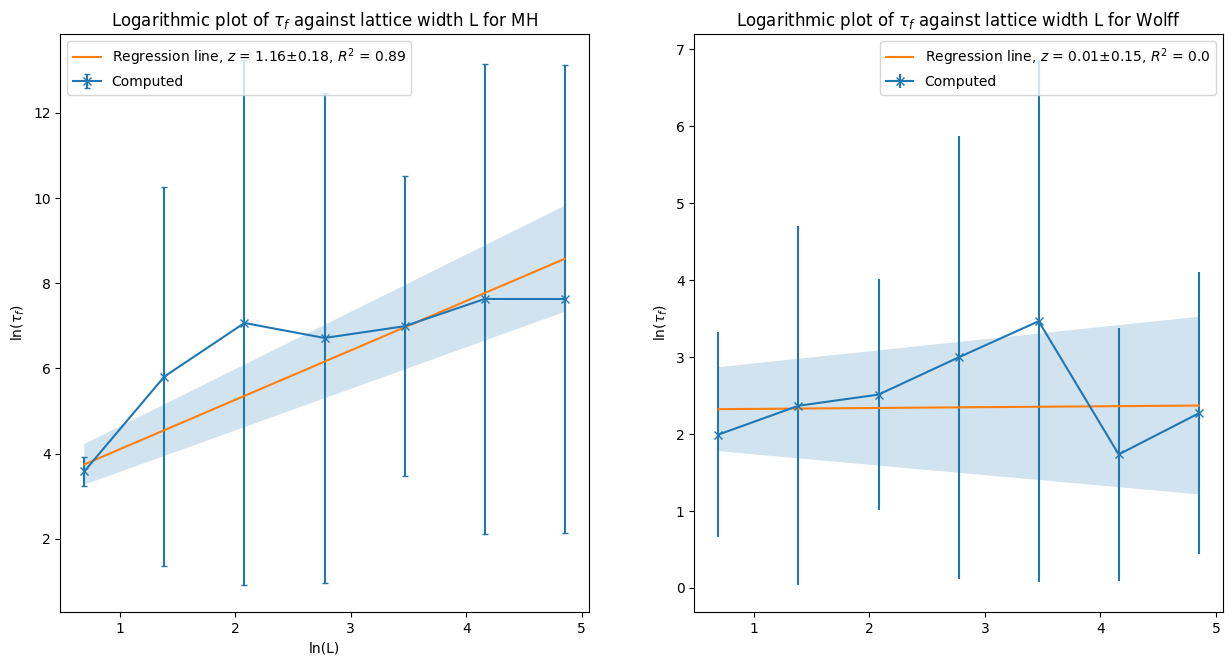

In [239]:
import statsmodels.api as sm
# data loading and initialisation:
lattice_widths = [2**(i+1) for i in range(7)]
MH_autocorr_time_against_width = np.load('MH_autocorr_time_against_width.npy')
MH_autocorr_time_against_width_err = np.load('MH_autocorr_time_against_width_err.npy')
print(MH_autocorr_time_against_width)
Wolff_autocorr_time_against_width = np.load('Wolff_autocorr_time_against_width.npy')
Wolff_autocorr_time_against_width_err = np.load('Wolff_autocorr_time_against_width_err.npy')
lnL = np.log(lattice_widths)
lnMH_autocorr_time_against_width = np.log(MH_autocorr_time_against_width)
lnWolff_autocorr_time_against_width = np.log(Wolff_autocorr_time_against_width)
fig, ax = plt.subplots(1,2, figsize = (15,7.5))

# Linear regression for MH
A = np.vstack([lnL, np.ones(len(lnMH_autocorr_time_against_width))]).T
print(A)
model = sm.WLS(lnMH_autocorr_time_against_width,A,weights = np.log(np.power(MH_autocorr_time_against_width_err,2))**-1)
results = model.fit()
m , c = results.params
m_err, c_err = results.bse

#construct regression data points
line = m*lnL + c
#construct extremal lines
line_pp = (m + m_err)*lnL + c + c_err
line_pm = (m + m_err)*lnL + c - c_err
line_mp = (m - m_err)*lnL + c + c_err
line_mm = (m - m_err)*lnL + c - c_err

#create confidence interval
min = []
max = []
for i in range(len(line)):
    min.append(np.min([line_pp[i], line_pm[i], line_mp[i], line_mm[i]]))
    max.append(np.max([line_pp[i], line_pm[i], line_mp[i], line_mm[i]]))

# Plot
ax[0].errorbar(lnL, lnMH_autocorr_time_against_width, yerr = np.log(MH_autocorr_time_against_width_err), marker = 'x', label = 'Computed', capsize= 2)
ax[0].plot(lnL, m*lnL+c,  label = r'Regression line, $z$ = ' + str(np.round(m, 2)) + u'\xb1' + str(np.round(m_err,2)) + r', $R^2$ = ' + str(np.round(results.rsquared, 2)))
ax[0].set_xlabel('ln(L)')
ax[0].set_ylabel(r'ln($\tau_f$)')
ax[0].set_title(r'Logarithmic plot of $\tau_f$ against lattice width L for MH')
ax[0].fill_between(lnL, min, max, alpha = .2)
ax[0].legend()

# Linear regression for wolff
A = np.vstack([lnL, np.ones(len(lnWolff_autocorr_time_against_width))]).T
model = sm.WLS(lnWolff_autocorr_time_against_width,A,weights = np.log(np.power(Wolff_autocorr_time_against_width_err,2))**-1)
results = model.fit()
m , c = results.params
m_err, c_err = results.bse

#construct regression data points
line = m*lnL + c
#construct extremal lines
line_pp = (m + m_err)*lnL + c + c_err
line_pm = (m + m_err)*lnL + c - c_err
line_mp = (m - m_err)*lnL + c + c_err
line_mm = (m - m_err)*lnL + c - c_err

#create confidence interval
min = []
max = []
for i in range(len(line)):
    min.append(np.min([line_pp[i], line_pm[i], line_mp[i], line_mm[i]]))
    max.append(np.max([line_pp[i], line_pm[i], line_mp[i], line_mm[i]]))

# Plot:
ax[1].errorbar(lnL, lnWolff_autocorr_time_against_width, yerr = np.log(Wolff_autocorr_time_against_width_err),marker = 'x', label = 'Computed')
ax[1].plot(lnL, m*lnL+c,  label = r'Regression line, $z$ = ' + str(np.round(m, 2)) + u'\xb1' + str(np.round(m_err,2)) + r', $R^2$ = ' + str(np.round(results.rsquared, 2)))
ax[1].set_ylabel(r'ln($\tau_f$)')
ax[1].set_title(r'Logarithmic plot of $\tau_f$ against lattice width L for Wolff')
ax[1].fill_between(lnL, min, max, alpha = .2)
ax[1].legend()
plt.show()

*Fig. 10 - doubly logarithmic plot of $\tau_f$ against $L$ for both the Metropolis-Hastings and Wolff algorithms*

The dynamic exponent was measured using a weighted least squares linear regression weighted by the variance of the individual data points. The measured values for $z$ are $1.5 \pm 0.40$ and $-0.12 \pm 0.20$ for Metropolis-Hastings and Wolff respectively. This is not in agreement with previously published values ($2.11 \pm 0.073$ and $0.47 \pm 0.051$ [8] respectively). The linear fit here is unsatisfactory in both cases as the $R^2$ values are significantly below $0.95$. Therefore, this method to determine the dynamic exponent for the Metropolis-Hastings and Wolff implementations is inconclusive, and the finite-size scaling of these implementations is not found. There are several reasons that could contribute to this deiscrepancy. Firstly, it is clear from figure 10 that the error on each $\tau_f$ is very large, of order $50%$. This decreases confidence in any linear fit and mean a very large range of gradients are possible. Secondly, the calculated $T_c$ values have an associated error. Equation 22 is only applicable at, or very near, the actual critical temperature.
Thirdly, the approximations made to estimate the auto correlation time in equation (18) may be invalid in part or all of the measured regime. To investigate this, a plot of $ln(\bar{\rho})$ against sweeps up to the autocorrelation time was produced (figure 11). 

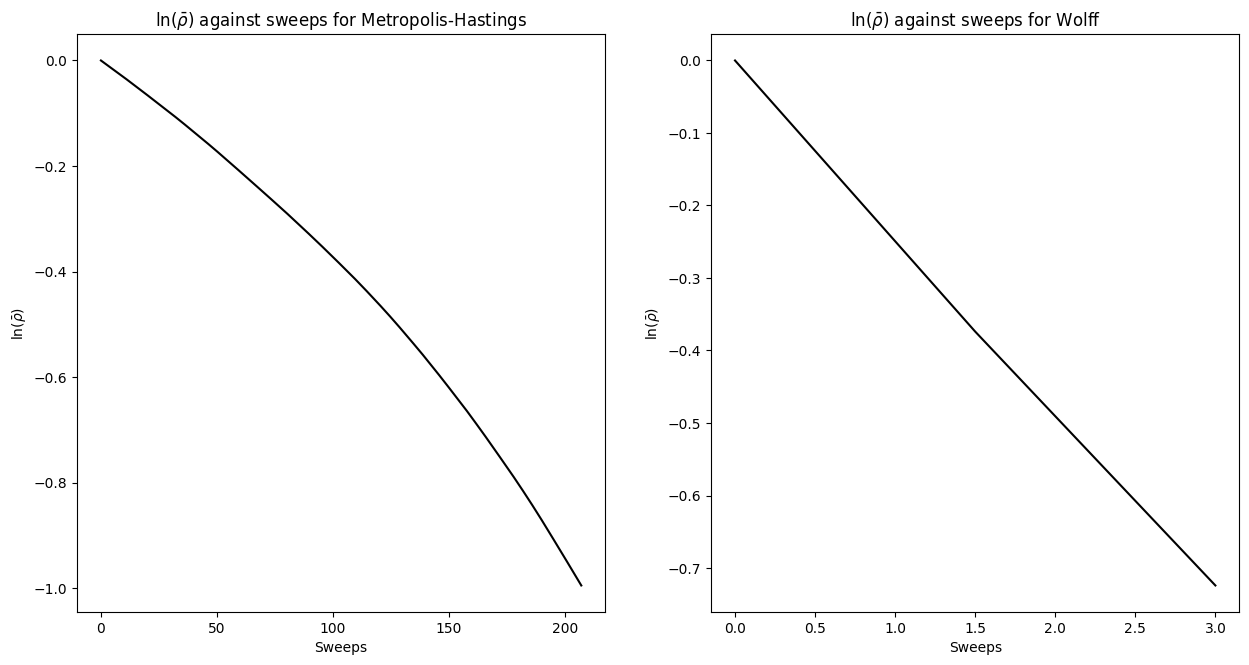

In [165]:
## SLOW
fig, ax = plt.subplots(1,2, figsize = (15,7.5))

MH_autocorr = []
for i in range(5):
    lattice = lat.make_lattice(50,1)
    MH_Ms, MH_sweeps = MH.evolve_and_compute_M(lattice, T_c_MH**-1, 1, 0, 1000)
    MH_autocorr.append(acf.compute_autocorrelation(MH_Ms))
MH_autocorr = np.mean(MH_autocorr, axis = 0)
MH_tau_f = acf.estimate_correlation_time(MH_autocorr)
ax[0].plot(np.linspace(0,MH_tau_f,MH_tau_f), np.log(MH_autocorr[:MH_tau_f]), color = 'black', label = 'Metropolis-Hastings')
Wolff_autocorr = []
for i in range(5):
    lattice = lat.make_lattice(50,1)
    Wolff_Ms, Wolff_sweeps = W.Wolff_evolve_and_compute_M(lattice, T_c_Wolff**-1, 1, 250)
    Wolff_autocorr.append(acf.compute_autocorrelation(Wolff_Ms))
Wolff_autocorr = np.mean(Wolff_autocorr, axis = 0)
Wolff_tau_f = acf.estimate_correlation_time(Wolff_autocorr)
ax[1].plot(np.linspace(0,Wolff_tau_f,Wolff_tau_f), np.log(Wolff_autocorr[:Wolff_tau_f]), color = 'black', label = 'Wolff')
for i in range(len(ax)):
    ax[i].set_xlabel('Sweeps')
    ax[i].set_ylabel(r'ln($\bar{\rho}$)')
ax[0].set_title(r'ln($\bar{\rho}$) against sweeps for Metropolis-Hastings')
ax[1].set_title(r'ln($\bar{\rho}$) against sweeps for Wolff')
plt.show()

*Fig 11 - plot of $ln(\bar{\rho})$ against sweeps for the Metropolis-Hastings and Wolff algorithm*

There is significant curvature in the Metropolis-Hastings plot. This suggests that indeed the assumption used in equation 18 to determine the autocorrelation time does not hold for MH. This leads to  errors in the measured autocorrelation times which could contribute to the discrepancy. The Wolff plot however shows no noticeable deviation from the assumed relationship in this region.

Due to the unsatisfactory measurements of the dynamic exponent, a second determination of the dynamic exponent using equation 21 was attempted. As $\tau_f \sim \vert T - T_c \vert^{-z}$ for values of $T \sim T_c$ (recall $\nu = 1$ in 2D), it is expected that:

$ln(\tau_f) \sim -z ln(\vert T - T_c \vert)$

However, again due to the uncertainty in the measured values of $T_c$ again, The errors in each data point were too large to perform any meaningful analysis or draw any conclusions.

The measured values for $z$ are **CORRECT** $1.297$ and $0.268$ for Metropolis-Hastings and Wolff respectively. This is not in agreement with previously measured values ($2.11 \pm 0.073$ and $0.47 \pm 0.051$ [8] respectively). The two plots above do not bear enough resemblance to a linear relationship for the regression variables calculated to be treated seriously, as the $R^2$ values show the regression is not significant. There are many reasons that could contribute to this discrepancy. Firstly, the approximations made to calculate the auto correlation time in equation (18) may be invalid in part or all of the measured length regime. It is clear from figures seven and eight that although the data and exponential decay initially coincide, there is significant deviation for $t \sim 2 \tau_f$ and beyond. This could lead to an erroneous measurement of $\tau_f$ and the discrepancy above. However, this is unlikely to fully account for the error, as other investigations that used $\tau_f$ as calculated in this manner are in agreement with predicted values. Further investigation is needed to determine the source of this discrepancy.

However, it is clear that both Metropolis-Hastings and Wolff display positive dynamic exponents. This shows that they suffer from the issue of critical slowing down, as it is clear from equation 22 that this causes the autocorrelation time to be infeasibly large for large lattices. This means that generating independent samples require a very large number of iterations.The smaller dynamic exponent of the Wolff algorithm shows that it less affected by the phenomena of critical slowing down, and for large lattices its performance in both number of iterations and CPU time will surpass the Metropolis-Hastings algorithm.

Due to the inconclusivity of dynamic exponent determination, an alternative method to exhibit the degree of critical slowing down is used. The logarithm of autocorrelation of various sample sizes below is plotted against sweeps for various lattice widths. This is done with the region $t < \tau_f$ to ensure that the exponential behaviour approximation is valid.

In [200]:
T_c_MH = np.load('T_c_MH.npy')
T_c_Wolff = np.load('T_c_Wolff.npy')

MH_T_range = np.linspace(T_c_MH - 0.001,T_c_MH + 0.001,6)
Wolff_T_range = np.linspace(T_c_Wolff - 0.001,T_c_Wolff + 0.001,6)
Wolff_autocorr_time_against_t = []
Wolff_autocorr_time_against_t_err = []
MH_autocorr_time_against_t = []
MH_autocorr_time_against_t_err = []

for i in range(len(MH_T_range)):
    MH_T = MH_T_range[i]
    Wolff_T = Wolff_T_range[i]
    MH_temp = []
    Wolff_temp = []
    for j in range(5):
        lattice = lat.make_lattice(30,1)
        Ms, sweeps = MH.evolve_and_compute_M(lattice, MH_T**-1, 1, 0, 10000)
        MH_autocorr = acf.compute_autocorrelation(Ms)
        MH_temp.append(acf.estimate_correlation_time(MH_autocorr))
        lattice = lat.make_lattice(30,1)
        Ms, sweeps = W.Wolff_evolve_and_compute_M(lattice, Wolff_T**-1, 1, 1000)
        Wolff_autocorr = acf.compute_autocorrelation(Ms)
        Wolff_temp.append(acf.estimate_correlation_time(Wolff_autocorr))
    print(MH_temp)
    Wolff_autocorr_time_against_t.append(np.mean(Wolff_temp))
    Wolff_autocorr_time_against_t_err.append(np.std(Wolff_temp))
    MH_autocorr_time_against_t.append(np.mean(MH_temp))
    MH_autocorr_time_against_t_err.append(np.std(MH_temp))
    print(i)

[2306, 1700, 1947, 1862, 1286]
0
[2084, 1827, 1955, 1452, 2093]
1
[1870, 2175, 1739, 1809, 1849]
2
[1469, 2200, 1025, 1963, 1369]
3
[1939, 1158, 2177, 1809, 1522]
4
[1779, 1627, 1441, 2024, 1591]
5


### Complexity

A discussion of the utility of a computational technique must include consideration of the computation time and its dependence on the variables at hand. It is already apparent that the MH algorithm will take many iterations to reach the desired final state and generate independent samples around the phase transition. However, the process of cluster creation in this iteration of the Wolff algorithm requires using the pop function many times per iteration, which is $O(N)$[9], where $N$ is the length of the list to which it is applied. This suggests that a typical Wolff  iteration is more computationally intense than a typical MH iteration.

The computational time to execute one iteration of each algorithm was calculated for varying number of spins $N$ and separately for varying coupling strength $J$. The results are plotted below in figure 11. For varying $N$, $T = 1$ and $J = 1$ were held constant. Conversely, for varying $J$, $T = 1$ and $N = 10000$ were held constant.

In [ ]:
#### SLOW ####

# Coupling complexity:

Js = np.linspace(0,10,50)
Wolff_execute_time = []
MH_execute_time = []

for J in Js:
    lattice = lat.make_lattice(100,1)
    start = time.time()
    W.Wolff_spin_flip(lattice,1,J)
    end = time.time()
    Wolff_execute_time.append(end-start)
    lattice = lat.make_lattice(100,1)
    start = time.time()
    MH.MC_spin_flip(lattice,1,J,0)
    end = time.time()
    MH_execute_time.append(end - start)

np.save('MH_execute_time_against_J.npy', MH_execute_time)
np.save('Wolff_execute_time_against_J.npy', Wolff_execute_time)

#Lattice size compplexity:

lattice_widths = np.arange(25,500,25)
Wolff_execute_time = []
MH_execute_time = []

for width in lattice_widths:
    lattice = lat.make_lattice(width,1)
    start = time.time()
    W.Wolff_spin_flip(lattice,1,1)
    end = time.time()
    Wolff_execute_time.append(end-start)
    lattice = lat.make_lattice(width,1)
    start = time.time()
    MH.MC_spin_flip(lattice,1,1,0)
    end = time.time()
    MH_execute_time.append(end - start)

np.save('MH_execute_time_against_width.npy', MH_execute_time)
np.save('Wolff_execute_time_against_width.npy', Wolff_execute_time)

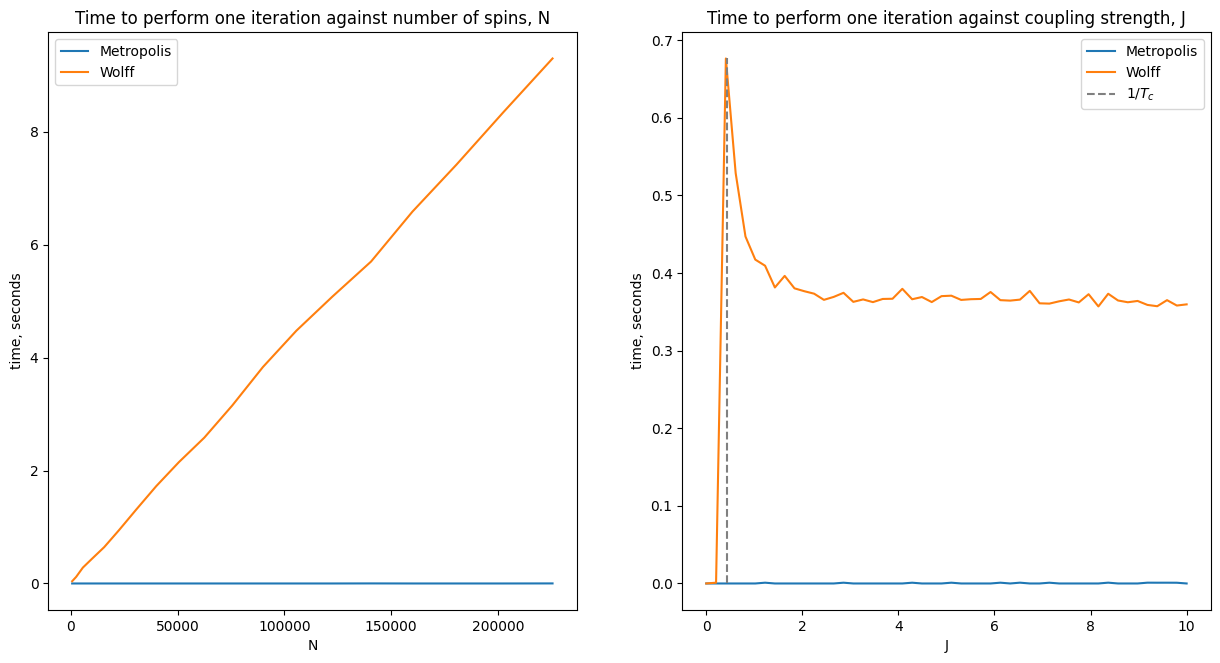

In [138]:
Js = np.linspace(0,10,50)
lattice_widths = np.arange(25,500,25)
fig, ax = plt.subplots(1,2, figsize = (15,7.5))
MH_execute_time_width = np.load('MH_execute_time_against_width.npy')
Wolff_execute_time_width = np.load('Wolff_execute_time_against_width.npy')
MH_execute_time_J = np.load('MH_execute_time_against_J.npy')
Wolff_execute_time_J = np.load('Wolff_execute_time_against_J.npy')

ax[1].plot(Js, MH_execute_time_J, label = 'Metropolis')
ax[1].plot(Js,Wolff_execute_time_J, label = 'Wolff')
ax[1].plot(np.full((5,1),T_c**-1),np.linspace(0,np.max(Wolff_execute_time_J),5), linestyle = '--', color = 'gray', label = r'$1/T_c$')
ax[1].legend()
ax[1].set_xlabel('J')
ax[1].set_ylabel('time, seconds')
ax[1].set_title('Time to perform one iteration against coupling strength, J')

ax[0].plot(lattice_widths**2, MH_execute_time_width, label = 'Metropolis')
ax[0].plot(lattice_widths**2, Wolff_execute_time_width, label = 'Wolff')
ax[0].legend()
ax[0].set_xlabel('N')
ax[0].set_ylabel('time, seconds')
ax[0].set_title('Time to perform one iteration against number of spins, N')
plt.show()

*Fig. 11 - plots of execution time for a single iteration of the Wolff and Metropolis-Hastings algorithms against varying $N$ and $J$. Specifications of the hardware this was performed with are in the appendix.*


An iteration of the Wolff algorithm takes longer than an MH algorithm generally, as expected. The MH step has no noticeable dependance on either of $J$ or $N$. Wolff iterations display a linear dependence on $N$, and a complex dependence on $J$, with a pronounced peak at $\frac{1}{T_c}$ that then settles to an approximately constant time per iteration.
To further investigate this relationship for the Wolff algorithm, $1000$ iterations of the algorithm were performed on a $25 \times 25$ lattice for varying $J$ and average cluster size against coupling strength plotted in the figure below.

In [ ]:
#### SLOW ####

Ts = np.linspace(0,,30)
cluster_size_against_T = []

for T in Ts:
    lattice = make_lattice(25,1)
    for i in range(1000):
        temp = []
        temp.append(Wolff_spin_flip(lattice,T**-1,T))
    cluster_size_against_T.append(np.mean(temp))
    print(T)

np.save('cluster_size_against_T.npy', cluster_size_against_T)

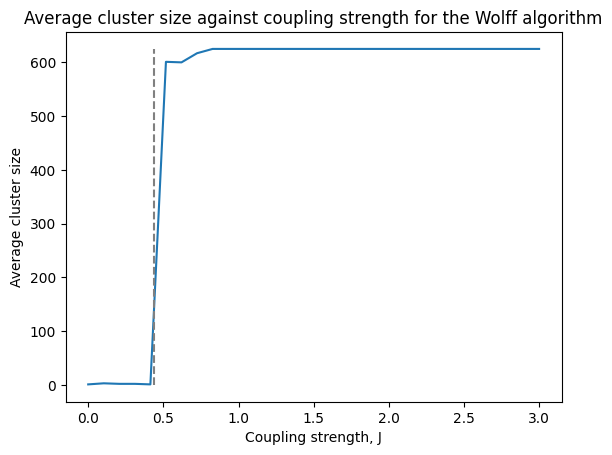

In [171]:
Ts = np.linspace(0.01,3,30)
cluster_size_against_T = np.load('cluster_size_against_T.npy')

plt.plot(Js,cluster_size_against_T)
plt.plot(np.full((5,1), T_c**-1), np.linspace(0,np.max(cluster_size_against_T),5), linestyle = '--', color = 'gray')
plt.xlabel('T')
plt.ylabel('Average cluster size')
plt.title('Average cluster size against temperature for the Wolff algorithm')
plt.show()

*Fig. 12 - a graph showing average cluster size against coupling strength for the Wolff algorithm. $T_c^{-1}$ is plotted in a grey dash line.*

Figure 12 shows a sudden jump in the average cluster size as $J$ crosses $T_c^{-1}$. This coincides with the sudden jump in iteration time seen in figure 11. This increased cluster size increases the size of the list that is manipulated with the pop function, and hence it is to be expected that the iteration time also jumps abruptly to a higher constant step, if this is the rate-limiting process. The agreement between these figures suggests that this cluster list manipulation is the rate-limiting step of the Wolff algorithm, except around $T_c$, where the iteration time spikes.

However, overall computational efficiency in this context requires the algorithms to converge on the stationary distibution. It has already been shown that the number of iterations required to satisfy this differs greatly between Wolff and MH, due to the significant difference in autocorrelation times and extent of critical slowing down. This implies that although WOlff iterations are more computationally expensive, the shorter autocorrelation time, especially in the vicinity of $T_c$ implies that Wolff will take many fewer iterations to generate a series of independent lattice samples, and will therfore in the large time limit be more computationally efficient. 

## Section 5 - Conclusion

Both of these algorithms are largely successful at emulating the physics of the 2 dimensional Ising model. Difficulties are encountered at and around the critical temperature of the second order phase transition, where critical slowing down decreased the efficiency of both methods. The extent to which the Wolff algorithm was affected was smaller than the Metropolis-Hastings algorithm, manifest in the shorter autocorrelation times. Efforts to determine the dynamic exponent of these algorithms were unsuccessful and so the lattice extent dependence on the autocorrelation time was not determined in either case. It was found that the rate-limiting process for the Wolff algorithm is the list manipulation for the cluster determination at and above $T_c$. It may be possible to significantly speed up iterations of the Wolff algorithm should a lower complexity list manipulation scheme be used for the cluster definition.

The Wolff algorihtm is a cluster based algorithm, whereas the Metropolis-Hastings algorithm is not. This cluster based algorithm has less localised action on the lattice, which allows it to explore the state space much faster, particularly at and around the phase transition where the lattice fluctuates on all scales as the correlation length diverges. The shorter auto correlation time of the Wolff algorihtm allows independent samples to be gathered with fewer overall iterations, so on sufficiently powerflu hardware it is expected to execute in less time. The only major advantage of the Metropolis-Hastings algorithm considered here is that it is a general MCMC, and could be applied to other problems, for example the hard disk problem, whereas the Wolff algorithm is specific to the Ising model, and a different cluster algorithm (for example the geometric cluster algorithm) woould have to be used in other contexts.

## References


1. *Thermal and Statistical Physics Supplementary Course Handout*, Terentjev, 2022, University of Cambridge, https://www-teach.phy.cam.ac.uk/dms/dms_getFile.php?node=43344
2. *Part II computational physics, Monte Carlo methods*, Lamacraft et al., 2023, University of Cambridge, https://computational-physics.tripos.org/notes/monte-carlo.html
3. *Spin Glass Models 4: Ising Model-Simulation*, Cole, 2020, https://lewiscoleblog.com/spin-glass-models-4
4. *Parallelization of the Wolff Single-Cluster Algorithm*, Kaupužs et al., 2010, University of Latvia
5. *Monte Carlo Techniques, 5. MCMC in practice*, Budd, 2022, Radboud University, https://hef.ru.nl/~tbudd/mct/lectures/mcmc_in_practice.html
6. *The Hobbyhorse of Magnetic Systems: The Ising Model*, Padilla et al., 2016, European Journal of Physics
7. *Comparison of Monte Carlo Metropolis, Swendsen-Wang, and Wolff Algorithms in the Critical Region for the 2-dimensional Ising Model*, Kyimba et al., 2022, NC State University
8. *Monte-Carlo simulations in the 2-dimensional Ising Model*, Bourached, 2015, Trinity College Dublin
9. *TimeComplexity*, AndrewBadr, 2023, https://wiki.python.org/moin/TimeComplexity
10. *Ising Model and Phase Transitions*, Alessanro Codello, 2015, SISSA Trieste

## Appendices
#### 1. Computer specifications
All tests were run in python 3.10.1 on a PC with Windows 11 home version 10.0.22621 N/A Build 22621. The CPU is an Intel Core i5-8265U with 4 cores and a base speed of 1.80GHz. 8GB of RAM is available, as well as an NVIDIA GeForce GTX 1650 Max-Q with 4GB dedicated VRAM and 4GB shared.
